# Ising model

The algorithm that is used to simulate the 2d Ising is called Metropolis. The steps go as follows:
1. Initialize the lattice randomly with 1 or -1 at each site. 1 is for when the magnet points up and -1 if for when it points down.
2. Randomly select a point on the grid. 
3. Calculate the change in the energy that would occur if we flipped the magnet. The energy is given by $E=-\sum_{i,j}s_i s_j$, where we sum over all pairs of points on the lattice and $s_i$ is $\pm 1$. If the change is negative, the system likes the change so the magnet is indeed flipped. If the change is positive, there is still a probability of $e^{-\frac{\Delta E}{T}}$ that the magnet gets flipped because of thermal fluctuations. Here $T$ is the temperature and $\Delta E$ is the change in energy that occurs when we flip the magnet.
4. Repeat step 3 for a number of steps equal to the size of a side of the lattice. This is considered as one time step. (This is where we update the value for the magnetization and the energy if interested in these quantites.)
5. Repeat steps 3 and 4 for a given number of time steps.
6. Plot, print the result.

# Simulation of the Ising model

We first import the usual libraries in order to do the simulation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math as m
import random

%matplotlib inline

The first function to create makes a square grid (simply a matrix) of a fixed size with random values at each element taken from -1 or 1. 

In [2]:
def initialize_grid(dim):
    '''
    Create a dim by dim array of numbers chosen randomly from -1 or 1.
    '''
    grid = np.random.choice([-1,1], size = (dim,dim))
    
    return grid

Next we make a function to plot a generic grid and add the option of putting a title. We need to create a color map where -1 is black and 1 is white. This will be useful to visualize results.

In [3]:
def plot_grid(grid, title=None):
    '''
    Plot grid with -1 being black and 1 being white with an option to add a title.
    '''
    # Create discrete colormap
    cmap = colors.ListedColormap(['black', 'white'])
    bounds = [-2,0,2]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    # Make plot
    fig, ax = plt.subplots()
    ax.imshow(grid, cmap = cmap, norm=norm)
    ax.set_title(title)

This is a function that computes the magnetization of a grid. This is simply the sum of all the elements and it is useful to classify the phase of the model.

In [4]:
def compute_magnetization(grid):
    return np.sum(grid)

This is one of the main functions of the algorithm. You give it a grid and two numbers that determine a position on the grid. The function first determines where the neighboring elements are. This is important because the grid has to be periodic so border elements are special. The change in energy due to reversing this element is then computed by adding all the contributions from the neighbors. Each one contributes by $$\Delta E=2*grid(i, j)*grid(i_{neighbor}, j_{neighbor})$$

In [5]:
def energy_change(grid, i, j):
    '''
    Assums a flip of the spin at position (i,j) on the grid and computes the change of
    energy due to it.
    Returns the change in energy.
    '''
    n = grid.shape[0]
    if (i==0):
        left = n-1
    else:
        left = i-1
    if (i==n-1):
        right = 0
    else:
        right = i+1
    if (j==0):
        down = n-1
    else:
        down = j-1
    if (j==n-1):
        up = 0
    else:
        up = j+1
    dE = 2 * grid[i,j] * (grid[left,j] + grid[right,j] + grid[i,up] + grid[i,down])
    return dE

This function picks a random element of the grid. The actual output is the indices of the element.

In [6]:
def random_spin(grid):
    '''
    Choose randomly the position of one entry in the array grid.
    Returns the location of the spin.
    '''
    n = grid.shape[0]
    x_index = random.randint(0, n-1)
    y_index = random.randint(0, n-1)
    return (x_index, y_index)

This is the second important function of the algorithm. It first uses the previously defined function to pick a random point on the grid. It then starts by computing the change in energy due to reversing this element by using the previously defined function. If the change is negative the element is indeed flipped. If not there is a probability $e^{-\Delta E/T}$ that the flip still happens. The output is the grid with (potentially) some random element reversed.

In [7]:
def spin_flip(grid, T):
    '''
    Picks randomly one spin on the grid and calculates the change in energy due to flipping the spin.
    If change is negative, flip the spin.
    If change is positive, flip it only with some probability.
    Returns the new grid with the spin potentially flipped.
    '''
    i, j = random_spin(grid)
    delta_E = energy_change(grid, i, j)
    if delta_E < 0:
        grid[i,j] = -grid[i,j]
    elif random.random() < m.exp(-delta_E/T):
        grid[i,j] = -grid[i,j]
    return grid

This is the main function of the simulation where we put everything together to run the algorithm. We start by initialize a random grid. We then run the random flip n times for one time step and then repeat the process for a determined number of time steps. The final grid is returned along with (potentially) the initial and final configurations.

In [8]:
def ising_simulation(n, T, steps=100, plot=False):
    '''
    Simulate 2d Ising model.
    Inputs:
    - n: size of the square lattice is n by n
    - T: temperature
    - steps: number of flips the algorithm tries to make
    - plot: decide if the grid is plotted at the beginning and the end of the simulation
    Returns:
    - the final grid
    - if plot is True, the initial and final grids in two plots
    '''
    grid = initialize_grid(n)
    
    if plot==True:
        plot_grid(grid, title='Initial grid')
        
    for i in range(steps):
        for i in range(n):
            grid = spin_flip(grid, T)
            
    if plot==True:
        plot_grid(grid, title='Final grid,' + 'Temperature T=' + str(T))
        
    return grid

array([[-1, -1, -1, ...,  1, -1, -1],
       [-1, -1, -1, ...,  1,  1, -1],
       [-1, -1, -1, ...,  1,  1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ...,  1,  1,  1]])

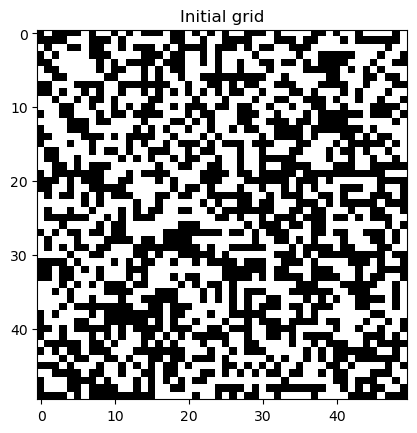

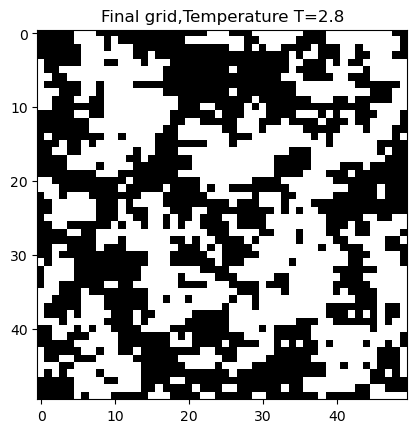

In [9]:
ising_simulation(50, 2.8, 3000, plot=True)

# Generating data

The code that we have so far simulates the Ising model and gives a grid back but we want to automate the production of data. The simulation is ran for different values of temperature evenly spread in a determined interval and for a fixed number of repetitions. The function records the final grids as a list of matrices and it also reshapes these grid into vectors and stacks them together to get the right form necessary for machine learning algorithms. The final step is to record in a vector if the temperature is above or below the critical one. The function prints the iteration as it runs to let us see what is going on.

In [10]:
def generate_data(size, num_temp, temp_min=1.0, temp_max=3.5, repeat=1, max_iter=None):
    '''
    Generate data from simulating the Ising model at different temperatures.
    The temperatures are spread equally between temp_min and temp_max.
    
    Input:
    - size: the grid is size x size
    - num_temp: number of different temperatures to consider
    - temp_min: minimum temperature to take
    - temp_max: maximum temperature
    - repeat: repeat the calculation for each temperature this number of times
    - max_iter: number of time steps in the simulation of the Ising model (default is size^2)
    
    Output:
    - raw_X: list of the arrays obtained from simulating the Ising (there are num_temp*repeat elements)
    - X: (num_temp, size^2) array where each line is a vectorized version of the grid and every line is a different run
    - y: (num_temp, 1) array that says if the simulation is made above the critical temps (y=1) or below (y=0)
    '''
    
    if max_iter==None:
        max_iter = size**2

    raw_X = []
    X = np.zeros((num_temp*repeat, size**2))
    y_label = np.zeros((num_temp*repeat, 1))
    y_temp = np.zeros((num_temp*repeat, 1))
    temps = np.linspace(temp_min, temp_max, num = num_temp)

    for i in range(repeat):
        for j in range(num_temp):
            grid = ising_simulation(size, temps[j], max_iter)
            raw_X.append(grid)
            X[i*num_temp+j,:] = grid.reshape(1,grid.size)
            y_label[i*num_temp+j,:] = (temps[j] > 2.269)
            y_temp[i*num_temp+j,:] = temps[j]
            print(i*num_temp+j, end="\r")
    
    return raw_X, X, y_label, y_temp

This generates data to use later for training your neural network model for a grid of 25 by 25.

In [14]:
raw_X, X, y_label, y_temp = generate_data(size=25, num_temp=51, repeat=20)

This uses the same grid and generates the test dataset.

In [38]:
raw_X_test, X_test, y_label_test, y_temp_test = generate_data(size=25, num_temp=21, repeat=20)

In [ ]:
# Evaluate classification model on test set
test_predictions_class = model_class.predict(X_test_class)
test_predictions_class_binary = (test_predictions_class > 0.5).astype(int).flatten()
test_accuracy = accuracy_score(y_test_class, test_predictions_class_binary)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate accuracy by temperature
test_temps = y_temp_test.flatten()
unique_temps = np.unique(test_temps)
accuracies_by_temp = []
temps_list = []

for temp in unique_temps:
    mask = test_temps == temp
    if np.sum(mask) > 0:
        temp_acc = accuracy_score(y_test_class[mask], test_predictions_class_binary[mask])
        accuracies_by_temp.append(temp_acc)
        temps_list.append(temp)

# Plot accuracy vs temperature
plt.figure(figsize=(10, 6))
plt.plot(temps_list, accuracies_by_temp, 'o-', linewidth=2, markersize=8)
plt.axvline(x=2.269, color='r', linestyle='--', label='Critical Temperature (Tc = 2.269)')
plt.xlabel('Temperature (T)', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('Problem A: Test Accuracy vs Temperature', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig('problem_a_accuracy_vs_temp.png', dpi=300, bbox_inches='tight')
plt.show()

print("\\nObservations:")
print("- Accuracy is highest far from critical temperature")
print("- Accuracy decreases near critical temperature (Tc = 2.269)")
print("- This is expected because configurations near Tc are more ambiguous")


label=:1
temperature=:2.9000000000000004


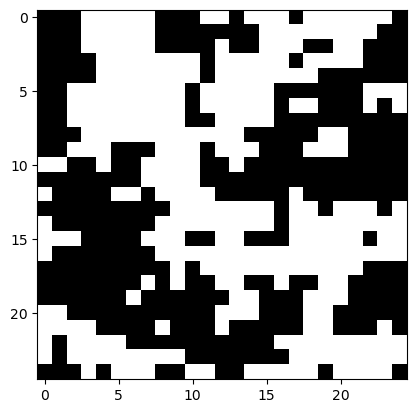

In [45]:
i = 701
plot_grid(raw_X[i])
print('label=:' + str(int(y_label[i])))
print('temperature=:' + str(float(y_temp[i])))